In [81]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import beta

In [82]:
INPUT_SIZE = 784
NUM_LAYERS = 2
NUM_HIDDEN_UNITS = 64
OUTPUT_SIZE = 10

NUM_EPOCHS = 10
BATCH_SIZE = 250
LEARNING_RATE = 0.1
MOMENTUM = 0.9

NUM_UNDERLYING_DISTRIBUTION = 30000

In [83]:
DATASET = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)

INDEX_UNDERLYING=list(range(NUM_UNDERLYING_DISTRIBUTION))
SUBSET_UNDERLYING=Subset(DATASET, INDEX_UNDERLYING)
LOADER_UNDERLYING=DataLoader(dataset=SUBSET_UNDERLYING, batch_size=BATCH_SIZE, shuffle=False)

In [84]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_layers-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    torch.manual_seed(1)
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [85]:
def get_bound(num_samples, eta, zeta, gamma, xi, alpha, delta):
    index_sample=np.random.choice(INDEX_UNDERLYING, num_samples, replace=False)
    index_find_delta,index_eval_bound=train_test_split(index_sample, test_size=xi)
    index_find_delta_train,index_find_delta_approx=train_test_split(index_find_delta, test_size=eta)
    index_eval_bound_train,index_eval_bound_ee=train_test_split(index_eval_bound, test_size=zeta)

    num_find_delta_approx=len(index_find_delta_approx)
    num_eval_bound_ee=len(index_eval_bound_ee)
    
    subset_find_delta_train=Subset(SUBSET_UNDERLYING, index_find_delta_train)
    subset_eval_bound_train=Subset(SUBSET_UNDERLYING, index_eval_bound_train)
    subset_eval_bound_ee=Subset(SUBSET_UNDERLYING, index_eval_bound_ee)

    loader_find_delta_train = DataLoader(dataset=subset_find_delta_train, batch_size=BATCH_SIZE, shuffle=True)
    loader_eval_bound_train = DataLoader(dataset=subset_eval_bound_train, batch_size=BATCH_SIZE, shuffle=True)
    loader_eval_bound_ee = DataLoader(dataset=subset_eval_bound_ee, batch_size=BATCH_SIZE, shuffle=False)

    model_find_delta = NeuralNet(INPUT_SIZE, NUM_LAYERS, NUM_HIDDEN_UNITS, OUTPUT_SIZE)
    model = NeuralNet(INPUT_SIZE, NUM_LAYERS, NUM_HIDDEN_UNITS, OUTPUT_SIZE)

    ReLU_glorot_init(model_find_delta)
    ReLU_glorot_init(model)

    criterion = nn.CrossEntropyLoss()
    optimizer_find_delta = SGD(model_find_delta.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    for epoch in range(NUM_EPOCHS):
        for images, labels in loader_find_delta_train:
            images = images.reshape(-1, INPUT_SIZE)
            outputs = model_find_delta(images)
            loss = criterion(outputs, labels)
            optimizer_find_delta.zero_grad()
            loss.backward()
            optimizer_find_delta.step()
        #print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss.item()))

    for epoch in range(NUM_EPOCHS):
        for images, labels in loader_eval_bound_train:
            images = images.reshape(-1, INPUT_SIZE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss.item()))

    true_accuracy_find_delta=0
    correct_bools=[]
    with torch.no_grad():
        for image, label in LOADER_UNDERLYING:
            image = image.reshape(-1, INPUT_SIZE)
            output = model_find_delta(image)
            predictions=output.max(1)[1]
            correct_bools+=(predictions==label).tolist()
            true_accuracy_find_delta+=sum((predictions==label).tolist())
    true_accuracy_find_delta/=NUM_UNDERLYING_DISTRIBUTION

    index_verifiable=[]
    index_not_verifiable=[]
    for k,correct in enumerate(correct_bools):
        if correct:
            index_verifiable.append(k)
        else:
            index_not_verifiable.append(k)

    prop_to_sample=min(1,gamma/true_accuracy_find_delta)
    Delta_prime, Delta=train_test_split(index_verifiable, test_size=prop_to_sample)

    Delta_prime+=index_not_verifiable

    num_Delta=len(Delta)
    num_Delta_prime=len(Delta_prime)

    subset_Delta=Subset(SUBSET_UNDERLYING, Delta)
    loader_Delta=DataLoader(dataset=subset_Delta, batch_size=BATCH_SIZE, shuffle=False)

    subset_Delta_prime=Subset(SUBSET_UNDERLYING, Delta_prime)
    loader_Delta_prime=DataLoader(dataset=subset_Delta_prime, batch_size=BATCH_SIZE, shuffle=False)

    empirical_accuracy_eval_bound=0
    with torch.no_grad():
        for image, label in loader_eval_bound_ee:
            image = image.reshape(-1, INPUT_SIZE)
            output = model(image)
            predictions=output.max(1)[1]
            empirical_accuracy_eval_bound+=sum((predictions==label).tolist())
    empirical_accuracy_eval_bound/=num_eval_bound_ee

    true_accuracy_Delta=0
    with torch.no_grad():
        for image, label in loader_Delta:
            image = image.reshape(-1, INPUT_SIZE)
            output = model(image)
            predictions=output.max(1)[1]
            true_accuracy_Delta+=sum((predictions==label).tolist())
    true_accuracy_Delta/=num_Delta

    true_accuracy_Delta_prime=0
    with torch.no_grad():
        for image, label in loader_Delta_prime:
            image = image.reshape(-1, INPUT_SIZE)
            output = model(image)
            predictions=output.max(1)[1]
            true_accuracy_Delta_prime+=sum((predictions==label).tolist())
    true_accuracy_Delta_prime/=num_Delta_prime

    p_hat=0
    for ind in index_find_delta_approx:
        if ind in Delta:
            p_hat+=1
    p_hat/=num_find_delta_approx
    p_L=beta.ppf(alpha,int(num_find_delta_approx*p_hat),int(num_find_delta_approx-num_find_delta_approx*p_hat+1))

    log_component = np.log((1-p_L+np.sqrt((1-p_L)**2+4*delta**(1/num_eval_bound_ee)*p_L))/(2*delta**(1/num_eval_bound_ee)))
    bound=(1-empirical_accuracy_eval_bound)+np.sqrt(log_component/2)-p_L*(1-true_accuracy_Delta)
    
    return 1-true_accuracy_Delta_prime, bound, p_L

In [100]:
ZETA=0.3
GAMMA=0.8
ALPHA=0.025
DELTA=0.025

SAMPLE_SIZE=10000
ETAS=np.linspace(0.01,0.1,9)
XIS=[0.3,0.5,0.7]
N_XIS=len(XIS)
N_ETAS=len(ETAS)
NUM_ITERATIONS=3

true_errors_delta_prime=[np.zeros(N_ETAS) for n in range(N_XIS)]
bounds=[np.zeros(N_ETAS) for n in range(N_XIS)]
ps=[]

for i, xi in enumerate(XIS):
    for n in range(NUM_ITERATIONS):
        for k,eta in enumerate(ETAS):
            true_error_delta_prime, bound, p = get_bound(SAMPLE_SIZE,eta,ZETA,GAMMA,xi,ALPHA,DELTA)
            bounds[i][k]+=bound/NUM_ITERATIONS
            ps.append(p)
            print('xi {} Iteration {} eta {}'.format(xi,n+1,eta))

xi 0.3 Iteration 1 eta 0.01
xi 0.3 Iteration 1 eta 0.02125
xi 0.3 Iteration 1 eta 0.0325
xi 0.3 Iteration 1 eta 0.043750000000000004
xi 0.3 Iteration 1 eta 0.05500000000000001
xi 0.3 Iteration 1 eta 0.06625
xi 0.3 Iteration 1 eta 0.0775
xi 0.3 Iteration 1 eta 0.08875000000000001
xi 0.3 Iteration 1 eta 0.1
xi 0.3 Iteration 2 eta 0.01
xi 0.3 Iteration 2 eta 0.02125
xi 0.3 Iteration 2 eta 0.0325
xi 0.3 Iteration 2 eta 0.043750000000000004
xi 0.3 Iteration 2 eta 0.05500000000000001
xi 0.3 Iteration 2 eta 0.06625
xi 0.3 Iteration 2 eta 0.0775
xi 0.3 Iteration 2 eta 0.08875000000000001
xi 0.3 Iteration 2 eta 0.1
xi 0.3 Iteration 3 eta 0.01
xi 0.3 Iteration 3 eta 0.02125
xi 0.3 Iteration 3 eta 0.0325
xi 0.3 Iteration 3 eta 0.043750000000000004
xi 0.3 Iteration 3 eta 0.05500000000000001
xi 0.3 Iteration 3 eta 0.06625
xi 0.3 Iteration 3 eta 0.0775
xi 0.3 Iteration 3 eta 0.08875000000000001
xi 0.3 Iteration 3 eta 0.1
xi 0.5 Iteration 1 eta 0.01
xi 0.5 Iteration 1 eta 0.02125
xi 0.5 Iteration 1 e

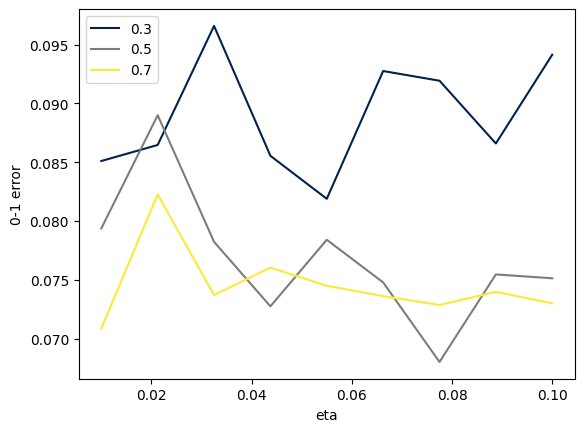

In [101]:
colors = plt.cm.cividis(np.linspace(0, 1, N_XIS))
for j, xi in enumerate(XIS):
    plt.plot(ETAS,bounds[j],color=colors[j],label=xi)
    plt.xlabel('eta')
    plt.ylabel('0-1 error')
plt.legend() 
plt.savefig('plots/MNIST_union_bound.png')